In [3]:
import torch
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

### Dataset

In [4]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
#Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {dataset[0].has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


In [5]:
from torch_geometric.utils import remove_isolated_nodes
print(dataset[0])
print(dataset[0].x.shape)
graph = dataset[0]

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
torch.Size([3327, 3703])


In [6]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
graph.edge_index.T

tensor([[   0,  628],
        [   1,  158],
        [   1,  486],
        ...,
        [3324, 2820],
        [3325, 1643],
        [3326,   33]])

In [8]:
from collections import Counter
print("Class Distribution:")
sorted(Counter(graph.y.tolist()).items())

Class Distribution:


[(0, 264), (1, 590), (2, 668), (3, 701), (4, 596), (5, 508)]

### Visualizing Graph

In [9]:
from torch_geometric.utils import to_networkx
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()
    
    if n_sample is not None:
        sample_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sample_nodes)
        y = y[sample_nodes]

    return g, y

def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()


C:\Users\blaze\AppData\Local\Temp\ipykernel_21768\3760948309.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample_nodes = random.sample(g.nodes, n_sample)


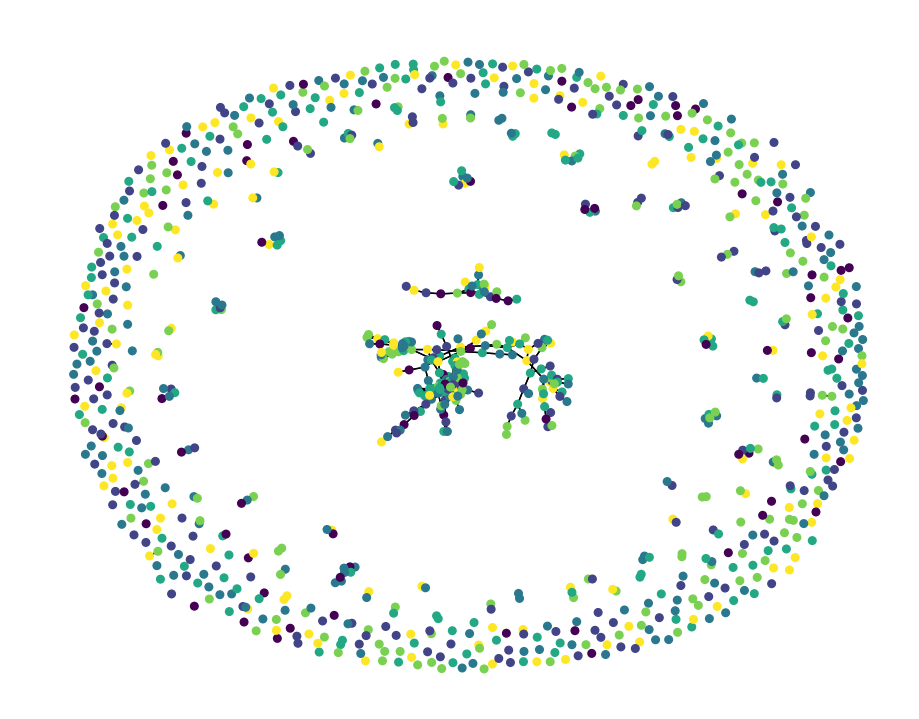

In [10]:
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

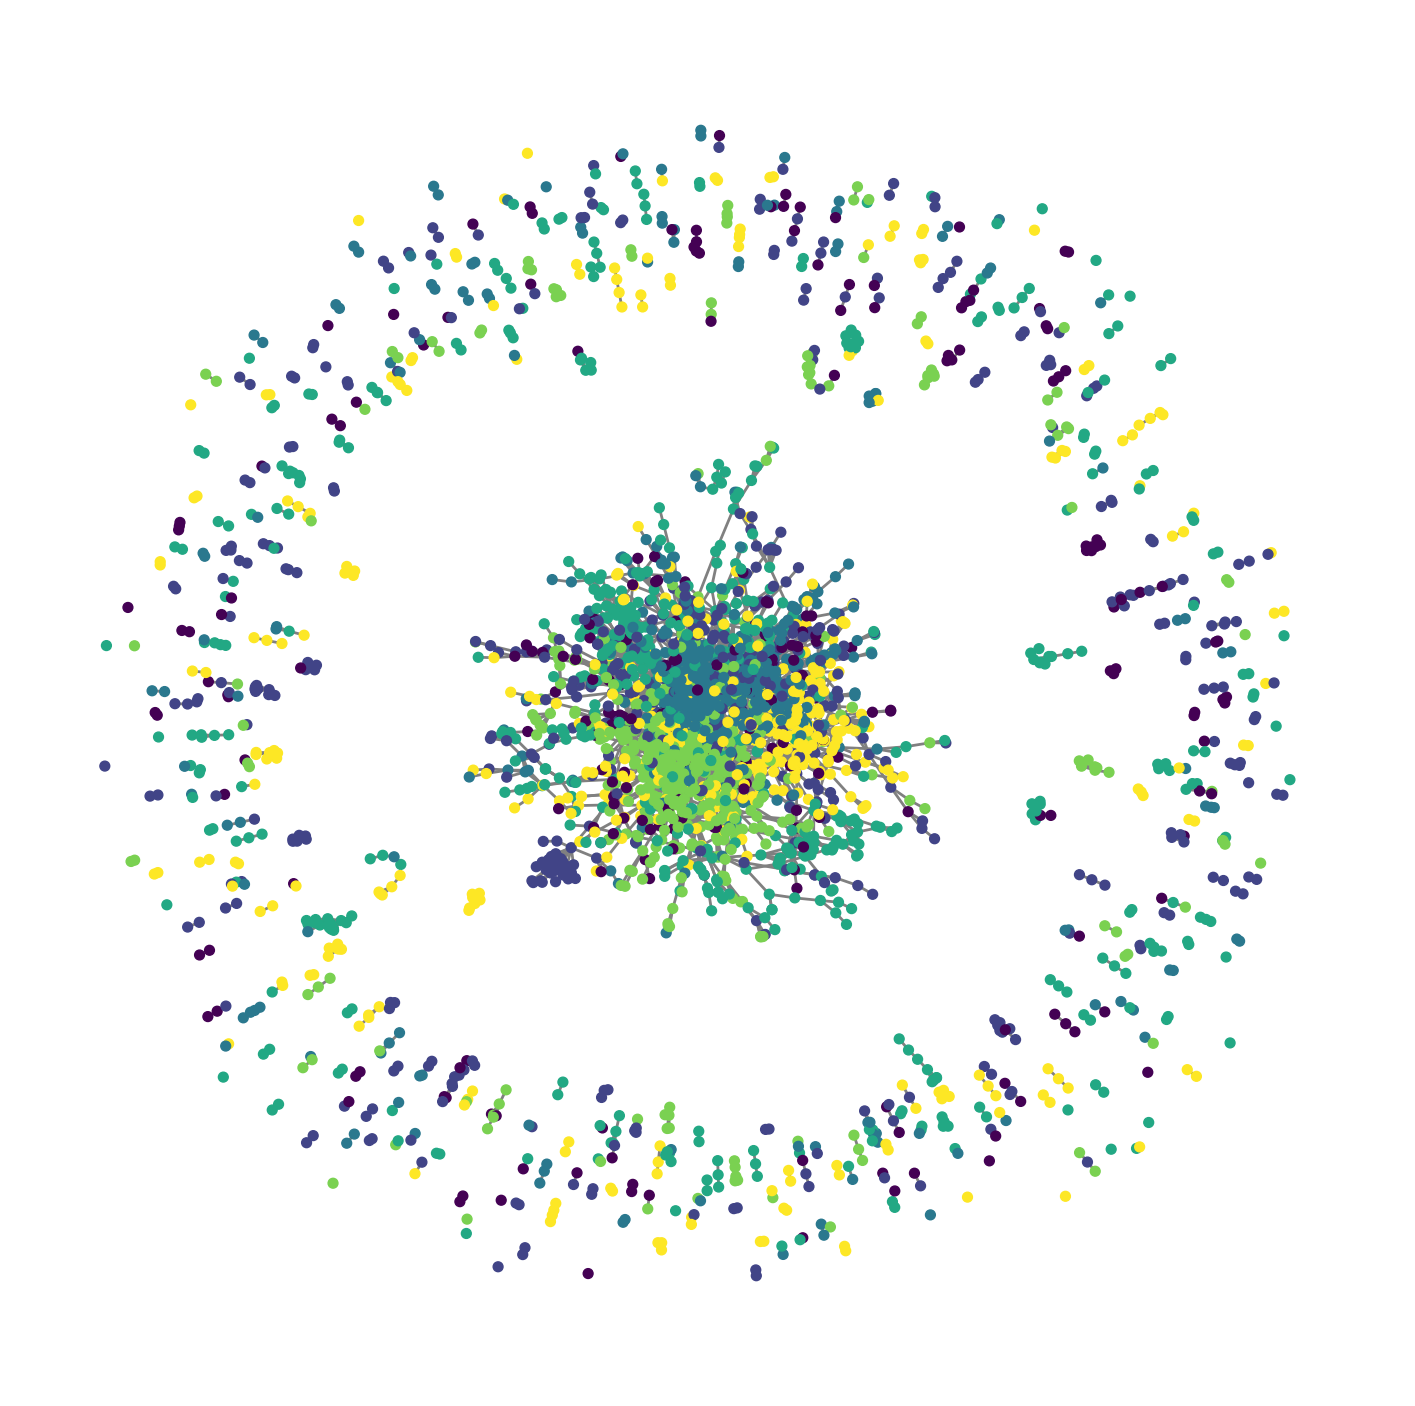

In [11]:
data = dataset[0]
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False, node_size=50, node_color=data.y, width=2, edge_color="grey")

plt.show()

<BarContainer object of 32 artists>

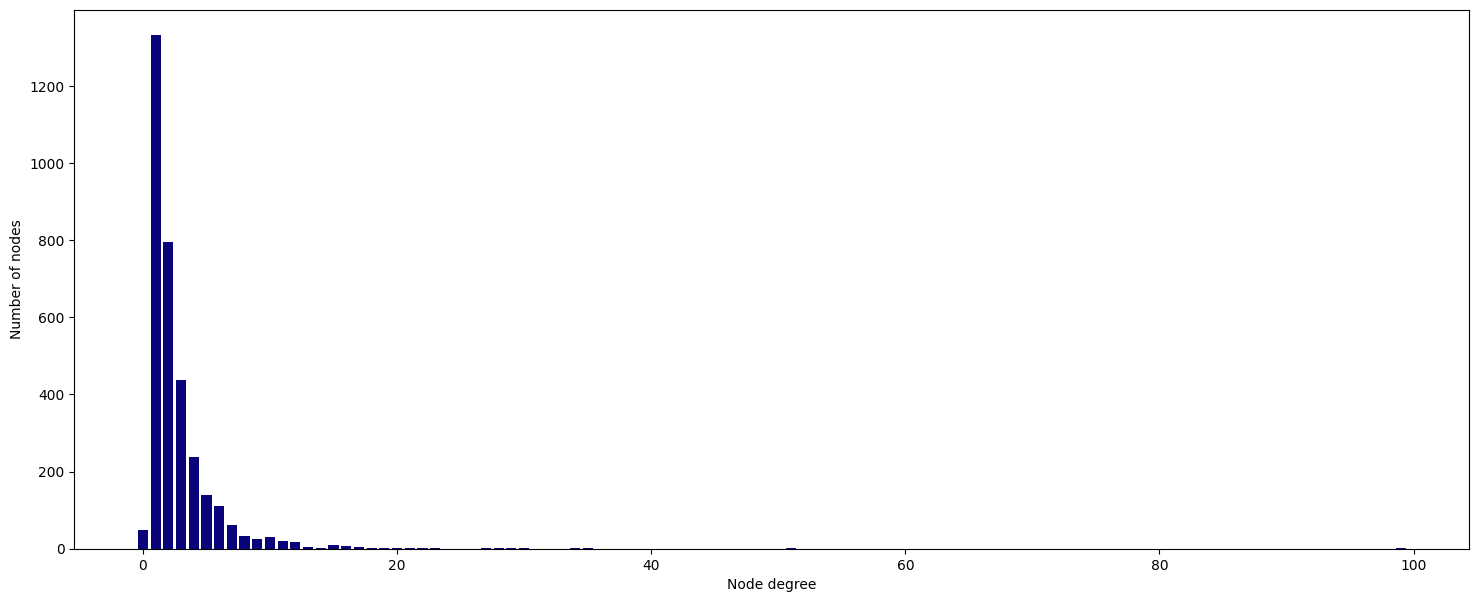

In [12]:
from torch_geometric.utils import degree

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [13]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv
import torch.nn as nn
from torch.optim import Adam

class GAT(nn.Module):
    "Graph Attention Network"
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return (pred_y == y).sum() / len(y)

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            print(out[data.train_mask])
          
    return model
        
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [14]:
# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.787 | Train Acc:  15.83% | Val Loss: 1.80 | Val Acc: 17.40%
tensor([[-1.7365, -1.7193, -1.8626, -1.9527, -1.7371, -1.7633],
        [-1.6844, -1.8304, -1.8228, -1.8780, -1.7209, -1.8281],
        [-1.5266, -1.5657, -1.9002, -1.8799, -1.8613, -2.1526],
        [-1.6578, -1.7285, -1.9047, -1.7427, -1.9452, -1.8017],
        [-1.8651, -1.6777, -1.7272, -1.7842, -1.7008, -2.0398],
        [-1.5196, -1.9833, -1.7529, -1.9325, -1.7932, -1.8383],
        [-1.5205, -1.7845, -1.8150, -1.7839, -1.9492, -1.9640],
        [-1.8065, -2.0088, -1.7600, -1.7097, -1.9481, -1.5794],
        [-1.8058, -1.7359, -1.7829, -1.7745, -1.8955, -1.7634],
        [-1.7441, -1.7670, -1.8405, -1.9776, -1.8833, -1.5841],
        [-1.8114, -1.7579, -1.7560, -1.8679, -1.7960, -1.7659],
        [-1.6262, -1.5512, -2.2270, -1.8263, -1.7776, -1.8745],
        [-1.7433, -1.7798, -1.6889, -1.8187, -1.8427, -1.8901],
 

### t-SNE plots

c:\Users\blaze\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


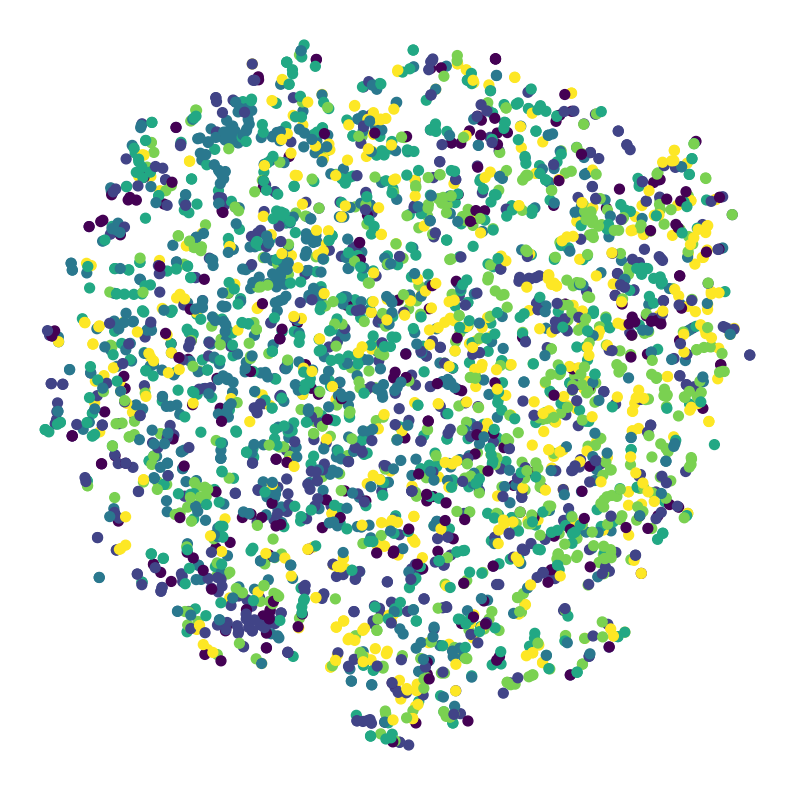

In [15]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

c:\Users\blaze\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


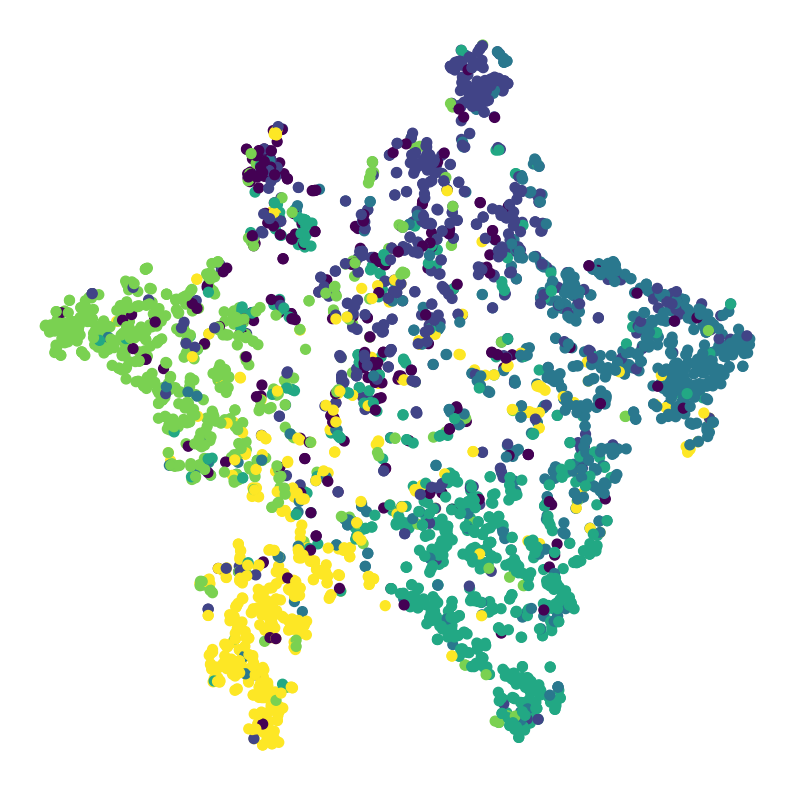

In [16]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

C:\Users\blaze\AppData\Local\Temp\ipykernel_21768\496808526.py:35: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plt.text(i, accuracies[i]//2, sizes[i],


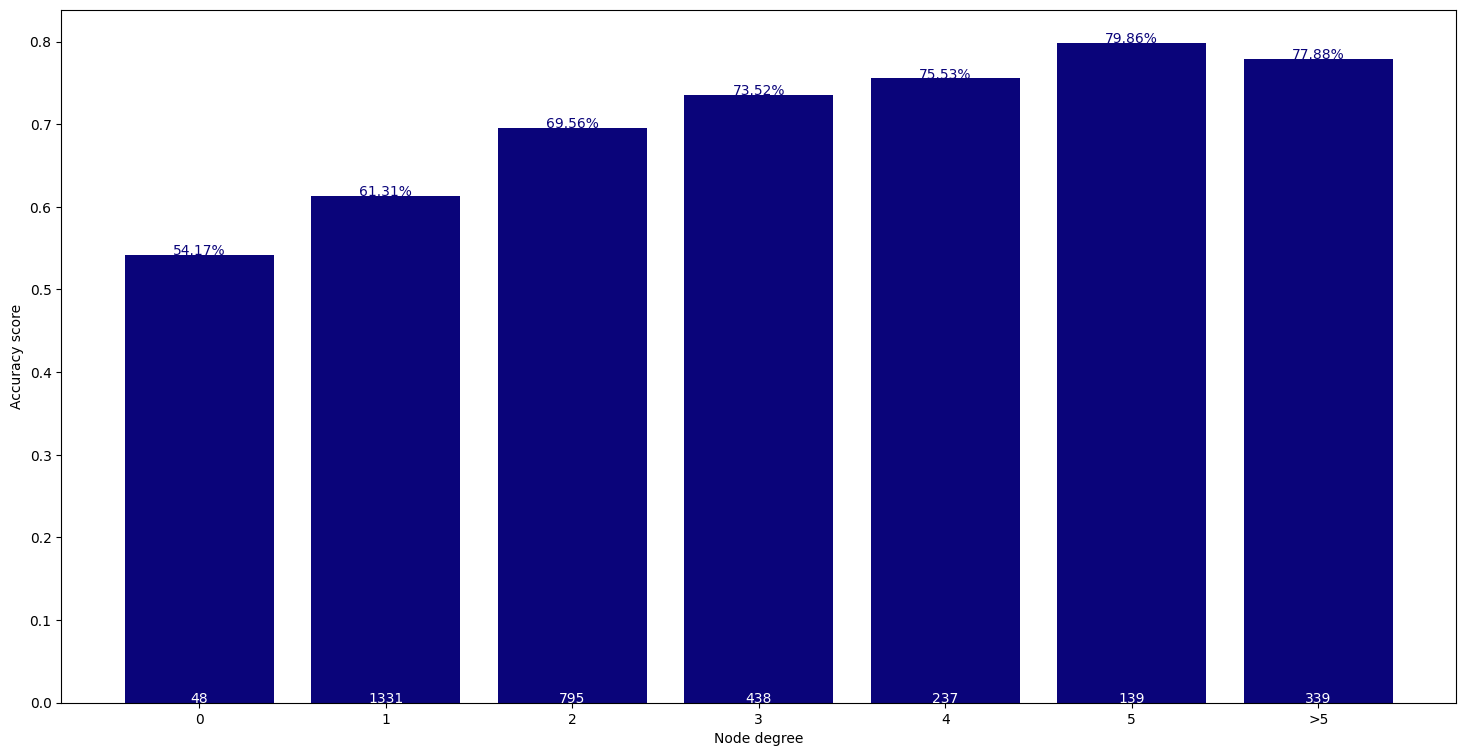

In [17]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

In [23]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])